In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.tools.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from pprint import pprint
import seaborn as sns
import networkx as nx
%matplotlib inline

# Question 1: Propensity score matching


In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?
#### Answer : 

We start by loading the data and viewing the first few observations. The data consists of 614 observations, for which we have 11 variables.
We proceed to dividing the data into two dataframes :
- **data_treat** : containing the 185 individuals who followed the training.
- **data_control** : containing the 429 individuals who didn't follow the training.

We note that *training* and *treatment* are used indifferently to describe the job training program ("National Supported Work Demonstration") that we are investigating.

In [3]:
#load the data
data = pd.read_csv("lalonde.csv")
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [4]:
#Split data into two dataframes (treatment and control)
data_treat = data[data.treat==1]
data_control = data[data.treat==0]


print(data_treat.shape)
print(data_control.shape)

(185, 11)
(429, 11)


#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

A fast and easy way to check whether the treatment had any effect on the real earnings of those who followed it, is to compute the distribution of the outcome variable (re78) and compare it between both groups.
Boxplots are used here to view these distributions.

([<matplotlib.axis.XTick at 0x2ee8caa8dd8>,
 <a list of 2 Text xticklabel objects>)

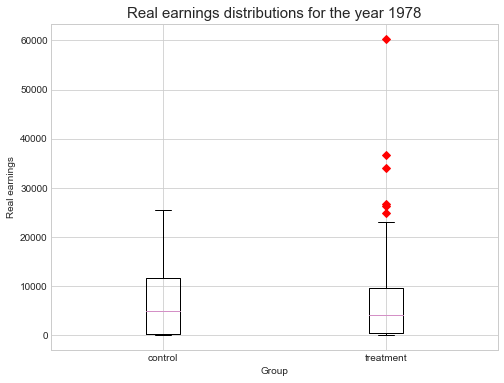

In [37]:
#Style
sns.set_style('whitegrid')
sns.set_palette('cubehelix',2)

#figure
plt.figure(figsize=(8,6))
plt.boxplot([data_control.re78,data_treat.re78],0,'rD')

#labels
plt.ylabel('Real earnings')
plt.xlabel('Group')    
plt.title('Real earnings distributions for the year 1978',size=15)
plt.xticks([1,2],['control','treatment'])

The difference between the distributions of the two groups is not as striking that one would expect. We observe that the medians are quite similar and both distrubutions have a longer tail towards the higher earnings. This is most likely due to the fact that some people have real earnings equal to zero. We also observe that the treatment group have a few more outiers than the control group.

To confirm the results of this figure, we create a table containing the numerical values of these statistics.

In [7]:
#Descriptive statistics 
descrip = pd.DataFrame()
descrip['control'] = data_control['re78'].describe()
descrip['treatment'] = data_treat['re78'].describe()
np.round(descrip, decimals=2)

,control,treatment
count,429.00,185.00
mean,6984.17,6349.14
std,7294.16,7867.40
min,0.00,0.00
25%,220.18,485.23
50%,4975.50,4232.31
75%,11688.82,9643.00
max,25564.67,60307.93


In the table above, we see that both the median and the mean are actually higher in the control group. Although the treatment group has some big outliers (as observed on the boxplot), the control group has a larger 75% quantile which means there are more people in this group having larger salaries.
We also notice that the treatment group has real earnings of value zero, which means that some of the trained people ended up unemployed anyway.
In the light of this superficial analysis, one might conclude that the training didn't work, or even decreased people's chances at a better salary.

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

#### Answer :

We will now perform a deeper analysis of the problem. Indeed, since this data is collected from an observational study, the assignment process into treatment or control groups might not have been completely random. In order to check this, we will study the distributions of the rest of the variables and try to detect any differences between the two groups.

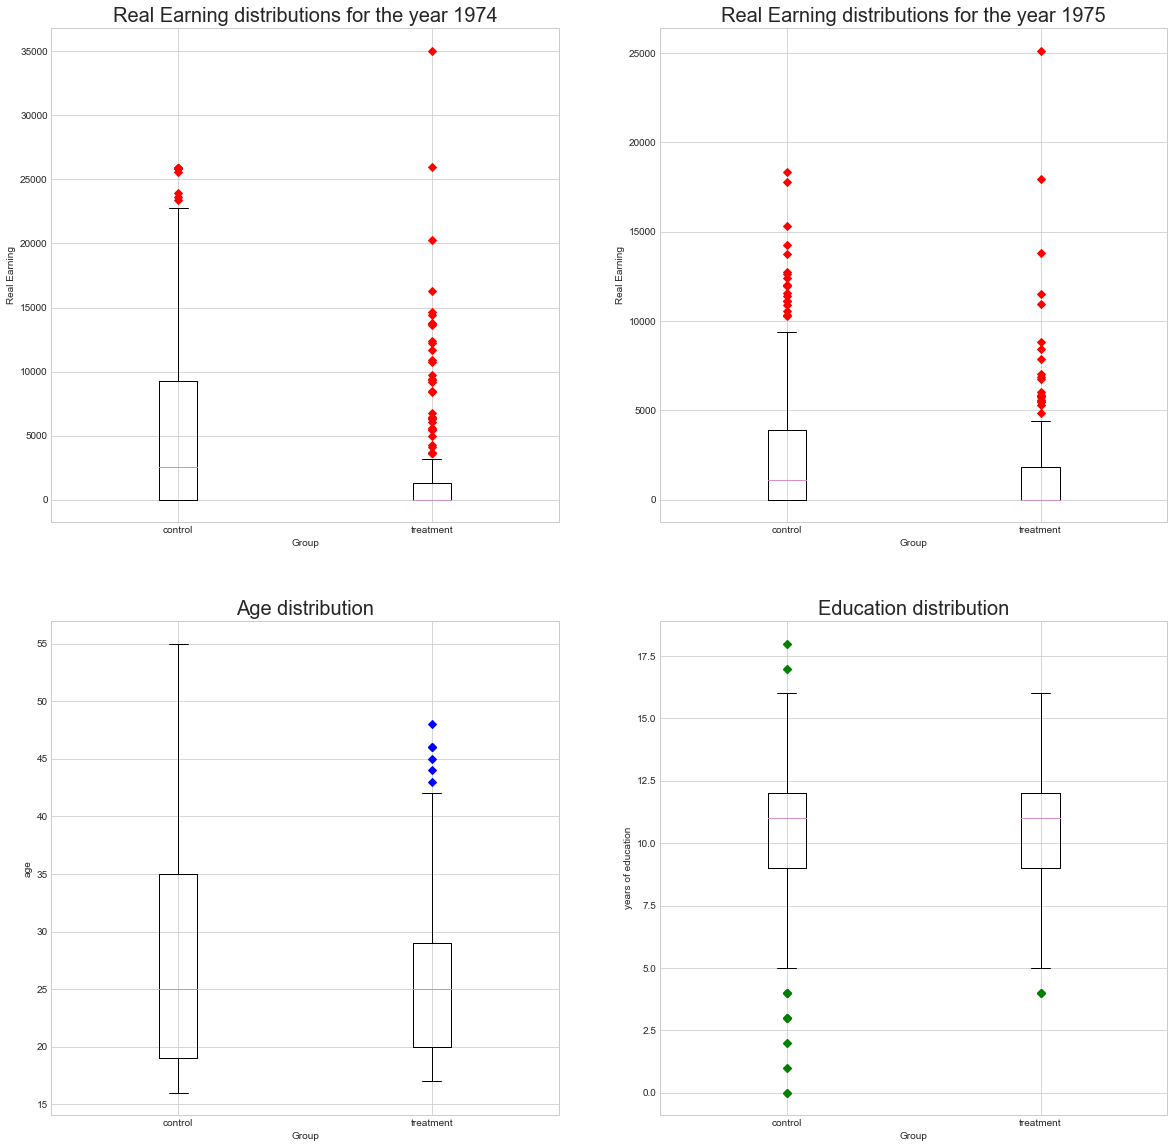

In [8]:
#figure
plt.figure(figsize=(20,20))

#boxplot for real ernings 1974
plt.subplot(221)
plt.boxplot([data_control.re74,data_treat.re74],0, 'rD')
plt.ylabel('Real Earning')
plt.xlabel('Group')    
plt.title('Real Earning distributions for the year 1974',size=20)
plt.xticks([1,2],['control','treatment'])

#boxplot for real earnings 1975
plt.subplot(222)
plt.boxplot([data_control.re75,data_treat.re75],0, 'rD')
plt.ylabel('Real Earning')
plt.xlabel('Group')    
plt.title('Real Earning distributions for the year 1975',size=20)
plt.xticks([1,2],['control','treatment'])

#boxplot for age
plt.subplot(223)
plt.boxplot([data_control.age,data_treat.age], 0, 'bD')    
plt.title('Age distribution',size=20)
plt.ylabel('age')
plt.xlabel('Group')    
plt.xticks([1,2],['control','treatment'])

#boxplot for education
plt.subplot(224)
plt.boxplot([data_control.educ,data_treat.educ], 0, 'gD')    
plt.title('Education distribution',size=20)
plt.ylabel('years of education')
plt.xlabel('Group')    
plt.xticks([1,2],['control','treatment'])
plt.show()

We start with boxplots of the real earnings for the years preceeding the treatment.
From the boxplots above, we can clearly see that the medians in the treatment groups are equal to zero, which means that at least half of the group was unemployed before the treatment. The control group however shows a positive median, as well as  larger 75% quantiles. Although the treatment group shows some extreme outliers, it seems that overall, the people who are involved tend to have lower initial salaries.
This might be interpreted as a discriminating factor between the groups: since they didn't start at the same level of income, they cannot be fairly compared after the treatment. Thus we conclude that the naive analysis we did in the previous question is in fact invalid.

The distributions for age and eduction are not too different (i.e we cannot say that one group is younger than the other or more educated), but the fact that the control group is larger (429) makes it cover a broader range of age and education values. 

Finally, we compute the proportion of each categorical variable in the groups:

In [9]:
#compute the number of black/hispanic/married/nodegree person in each group
control_ratio = data_control.iloc[:,4:8].sum()
treat_ratio = data_treat.iloc[:,4:8].sum()

#divide it by the total size of the group 
ratio = pd.DataFrame([100*control_ratio/len(data_control),100*treat_ratio/len(data_treat)])
ratio.index = ['control','treatment']
np.round(ratio,decimals=1)

,black,hispan,married,nodegree
control,20.3,14.2,51.3,59.7
treatment,84.3,5.9,18.9,70.8


The ratios are not equal for both groups, the most striking difference can be seen in the proportion of black people (20% of the control group and more than 80% of the treatment group ).
This confirms that the control and treatment groups do not represent the same population and thus the effect of the treatment cannot be judged accurately when compared to this control group.

#### Answer : 
In this section, we will compute the propensity scores via logistic regression in order to estimate the probability for each person of receiving the treatment given their known characteristics.

In [10]:
from sklearn import linear_model
logistic = linear_model.LogisticRegression()

In [36]:
#fitting logistic model to relevant parameters
covariates =data[['age', 'educ', 'black', 'hispan', 'married', 'nodegree','re74','re75']]
X = covariates
Z = data.treat
logistic.fit(X,Z)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Now that we have trained the model on the dataset, we will use it to compute the propensity scores for each observation. Then we add the values to the dataset.

In [12]:
propensity = logistic.predict_proba(X)

In [13]:
#adding the probabilities for each individual to the dataframe
prop = pd.DataFrame(propensity)
prop.columns = ['prob_control' ,'prob_treat']
data = pd.concat([data,prop['prob_treat']],axis=1)

data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prob_treat
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

#### Answer:

In order to perfom the matching, we must first translate our data into a bipartite graph C $\cup$ T, where each node is an observation from the data, C is the subset of control observations and T is the subset of treatment observations.
We assign to each node a list of attributes that will help construct the edges. For now these attributes consists of the propensity score and an indicator of wether the person was treated or not.

Our matching aims at linking together pairs of control and treatment observations which have close propensity scores.

For this purpose we create edges linking every treatment node to all control nodes and assign each edge a weight defined as the absolute difference between the propensities of the nodes it connects.
As we want to minimize these differences we simply add a minus to the absolute difference and then apply a maximum weighted matching to our graph.

Note that since edges only exist between nodes of different subsets the graph is bipartite as it should be.

In [14]:
#create empty graph
G = nx.Graph()

#for each node we add relevant attributes 
for k in range(len(data)):
        G.add_node(k, idf=data.id[k], prop=data.prob_treat[k], treat=data.treat[k])

#print an example         
print(G.nodes[0])

{'idf': 'NSW1', 'treat': 1, 'prop': 0.4433504229538332}


In [15]:
#for every treatment node we find all control nodes and add an edge with the desired weight 
for i in G.nodes():
    if G.nodes[i]['treat'] == 1:
        for j in G.nodes():
            if G.nodes[j]['treat'] == 0:
                W = -abs(G.nodes[i]['prop'] - G.nodes[j]['prop'])
                G.add_edge(i, j, weight=W )

To verify the graph we just created, we compute a few important numbers.

In [16]:
#print key numbers
print ('Number of nodes in the graph: {}'.format(G.number_of_nodes()))
print('Number of edges in the graph: {}'.format(G.number_of_edges()))

#We check if the graph is bipartite: 
if (nx.is_bipartite(G)):
    print( 'The graph is bipartite')

Number of nodes in the graph: 614
Number of edges in the graph: 79365
The graph is bipartite


We see that the graph is bipartite and contains the same amount of nodes as datapoints in our dataset. The amount of edges is supposed to be:

$N_{treat} \cdot N_{control} = 185 \cdot 429 = 79.365$ 

Which is (luckily) the amount of edges the we have.

Next we have to do the actual matching. This will correspond to keeping the edges that yeilds the highest sum of weights (recall the weight is minus the absolute difference of propensity scores) and at the same time only keeping one edge between any nodes.

In practice this is done using the networkX function shown below.

In [17]:
matching=nx.max_weight_matching(G,True)

In [18]:
#subset of treated observations
T = data[data.treat==1]

#subset of control observations
#initializing dataframe
C = pd.DataFrame([])

#adding rows from data where index is equal to the node matched to each treatment node
for k in range(0,185):
    C = pd.concat([C,data[data.index == matching[k]]])

To examine whether the resulting groups are now more balanced than the initial ones, we take a look at the descrptive statistics and compare them.

In [19]:
np.round(T.describe(), decimals=2)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prob_treat
count,185.0,185.00,185.00,185.00,185.00,185.00,185.00,185.00,185.00,185.00,185.00
mean,1.0,25.82,10.35,0.84,0.06,0.19,0.71,2095.57,1532.06,6349.14,0.56
std,0.0,7.16,2.01,0.36,0.24,0.39,0.46,4886.62,3219.25,7867.40,0.21
min,1.0,17.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04
25%,1.0,20.00,9.00,1.00,0.00,0.00,0.00,0.00,0.00,485.23,0.48
50%,1.0,25.00,11.00,1.00,0.00,0.00,1.00,0.00,0.00,4232.31,0.67
75%,1.0,29.00,12.00,1.00,0.00,0.00,1.00,1291.47,1817.28,9643.00,0.71
max,1.0,48.00,16.00,1.00,1.00,1.00,1.00,35040.07,25142.24,60307.93,0.76


In [20]:
np.round(C.describe(), decimals=2)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prob_treat
count,185.0,185.00,185.00,185.00,185.00,185.00,185.00,185.00,185.00,185.00,185.00
mean,0.0,23.71,10.16,0.47,0.12,0.17,0.63,2095.89,1615.31,5312.47,0.37
std,0.0,9.64,2.86,0.50,0.32,0.37,0.48,4029.20,2674.75,5842.88,0.25
min,0.0,16.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04
25%,0.0,17.00,9.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16
50%,0.0,19.00,10.00,0.00,0.00,0.00,1.00,289.97,451.16,3392.86,0.18
75%,0.0,26.00,12.00,1.00,0.00,0.00,1.00,2068.99,1890.58,7933.91,0.68
max,0.0,55.00,18.00,1.00,1.00,1.00,1.00,21918.32,13776.53,20243.38,0.78


We see that for most variables the means and the medians are quite similar. We note that the average propensity score is different in the treatment and control group. To examine the varables further, we look at the distributions.

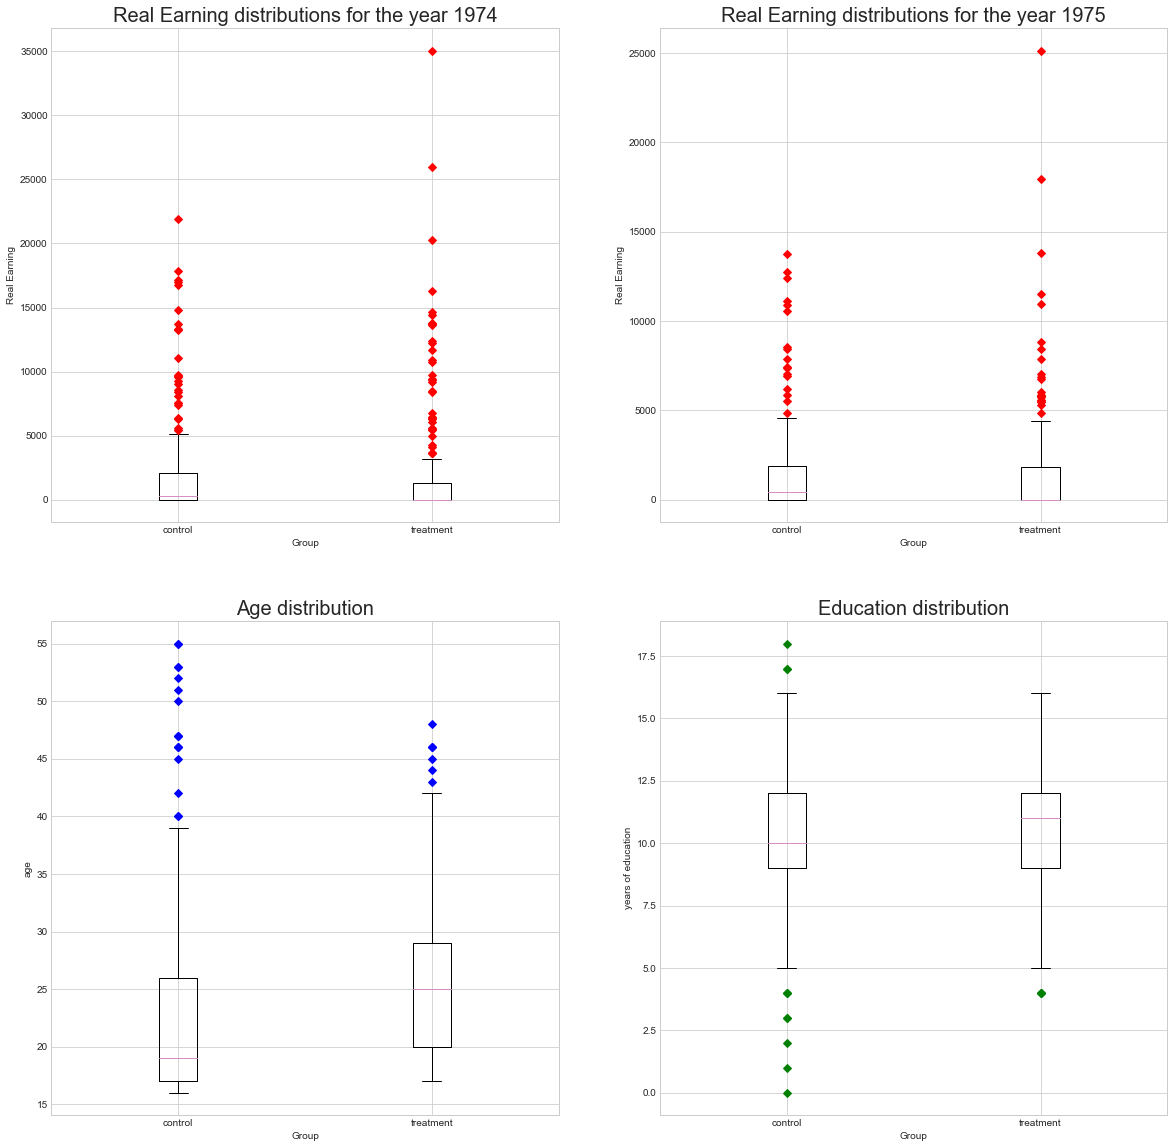

In [21]:
plt.figure(figsize=(20,20))

#boxplot for real earning 1974
plt.subplot(221)
plt.boxplot([C.re74,T.re74],0, 'rD')
plt.ylabel('Real Earning')
plt.xlabel('Group')    
plt.title('Real Earning distributions for the year 1974',size=20)
plt.xticks([1,2],['control','treatment'])

#boxplot for real earnings 1975
plt.subplot(222)
plt.boxplot([C.re75,T.re75],0, 'rD')
plt.ylabel('Real Earning')
plt.xlabel('Group')    
plt.title('Real Earning distributions for the year 1975',size=20)
plt.xticks([1,2],['control','treatment'])

#boxplot for age
plt.subplot(223)
plt.boxplot([C.age,T.age], 0, 'bD')    
plt.ylabel('age')
plt.xlabel('Group')
plt.title('Age distribution',size=20)
plt.xticks([1,2],['control','treatment'])

#boxplot for education
plt.subplot(224)
plt.boxplot([C.educ,T.educ], 0, 'gD')    
plt.ylabel('years of education')
plt.xlabel('Group')
plt.title('Education distribution',size=20)
plt.xticks([1,2],['control','treatment'])


plt.show()

We see that the real earnings of 1974 and 1975 are now much more similar for the two groups. However for both education and age the differences seems to be larger now.

We also want to see if the categorical values are similar enough after the matching.

In [22]:
#compute the number of black /hispanic/married/nodegree person in each group
C_ratio=C.iloc[:,4:8].sum()
T_ratio=T.iloc[:,4:8].sum()

# divide it by the total size of the group 
ratio=pd.DataFrame([100*C_ratio/len(C),100*T_ratio/len(T)])
ratio.index=['control','treatment']
ratio

,black,hispan,married,nodegree
control,47.027027,11.891892,16.756757,62.702703
treatment,84.324324,5.945946,18.918919,70.810811


We see that in general they are now quite similar except for the ratio of black people, that is still way higher in the treatment group.

Let's see if the outcome (namely the real earnings in 1978) looks different after the matching.

([<matplotlib.axis.XTick at 0x2ee8942a160>,
 <a list of 2 Text xticklabel objects>)

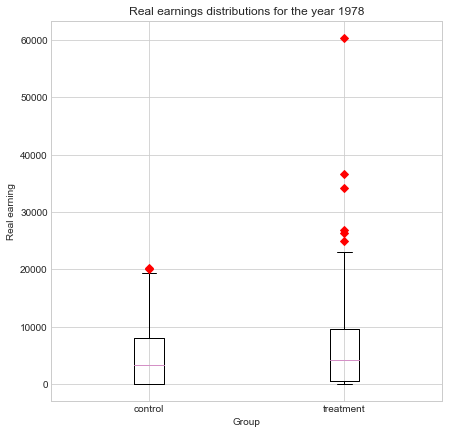

In [23]:
#create a figure
plt.figure(figsize=(7,7))
plt.boxplot([C.re78,T.re78],0, 'rD')
plt.ylabel('Real earning')
plt.xlabel('Group')    
plt.title('Real earnings distributions for the year 1978')
plt.xticks([1,2],['control','treatment'])

We observe that the real earnings for the treatment group is now better than for the control group. The median seems to be a bit higher and there are also more very high values. Since we noticed that the goups are still not completely balanced, we need to investigate further before concluding.

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

**Answer:**

We will now try to improve the matching further based on the implications that were observed in the previous part. The two problematic features found in the previous part are the age and the ratio of black people. We will now try to fix these issue. We do that by creating a graph again with all datapoints as nodes and only adding edges between treated and control nodes that:
 - share the same value for the attribute 'black'
 - have an age difference smaller than two years

In [24]:
#we create a new graph, this time also adding black and age as an attribute to the nodes
G2 = nx.Graph()
for k in range(len(data)):
        G2.add_node(k, idf=data.id[k],prop= data.prob_treat[k],treat=data.treat[k],
                    black=data.black[k],age=data.age[k])

#print an example
G2.nodes[0]       

{'age': 37, 'black': 1, 'idf': 'NSW1', 'prop': 0.4433504229538332, 'treat': 1}

In [25]:
#we add edges between the nodes
for i in G2.nodes():
    if G2.nodes[i]['treat']==1:
        for j in G2.nodes():
            if ((G2.nodes[j]['treat']==0) & (G2.nodes[j]['black'] == G2.nodes[i]['black']) 
                & ((abs(G2.nodes[j]['age']-G2.nodes[i]['age']))<2)):
                    W = -abs(G2.nodes[i]['prop'] - G2.nodes[j]['prop'])
                    G2.add_edge(i, j, weight=W )

In [26]:
#print key numbers
print ('number of nodes in the graph: '+str(G2.number_of_nodes()))
print('number of edges in the graph: '+str(G2.number_of_edges()))
#We check if the graph is bipartite: 
if (nx.is_bipartite(G2)):
    print( 'the graph is bipartite')

number of nodes in the graph: 614
number of edges in the graph: 2891
the graph is bipartite


Here we note that the amount of edges has decreased quite a lot. This is due to the fact that every treatment node is no longer matched to all control nodes, but only to the control nodes with which it shares the same value for 'black' (wether the person is black or not) and an age difference smaller than two.

We do a new round of matching:

In [27]:
# we do the max. weight matching 
matching=nx.max_weight_matching(G2,True)

In [28]:
#initialize dataframe for control and treatment observations
C2 = pd.DataFrame([])
T2 = pd.DataFrame([])

#adding rows from data
for k in range(0,185):
    if k in matching:
        C2 = pd.concat([C2,data[data.index == matching[k]]])
        T2 = pd.concat([T2,data[data.index == k]])

We look at the descriptive statistcs for the two groups again to see if they are more balanced.

In [29]:
np.round(T2.describe(), decimals=2)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prob_treat
count,111.0,111.00,111.00,111.00,111.0,111.00,111.00,111.00,111.00,111.00,111.00
mean,1.0,24.75,10.05,0.74,0.1,0.21,0.76,1888.18,1618.48,6445.50,0.51
std,0.0,8.10,1.88,0.44,0.3,0.41,0.43,4071.13,3698.79,7868.73,0.24
min,1.0,17.00,4.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.04
25%,1.0,19.00,9.00,0.00,0.0,0.00,1.00,0.00,0.00,800.61,0.19
50%,1.0,22.00,10.00,1.00,0.0,0.00,1.00,0.00,0.00,4482.84,0.65
75%,1.0,27.50,11.00,1.00,0.0,0.00,1.00,1872.25,1384.54,9647.83,0.70
max,1.0,48.00,14.00,1.00,1.0,1.00,1.00,20279.95,25142.24,60307.93,0.75


In [30]:
np.round(C2.describe(), decimals=2)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prob_treat
count,111.0,111.00,111.00,111.00,111.00,111.00,111.00,111.00,111.00,111.00,111.00
mean,0.0,24.58,10.49,0.74,0.07,0.26,0.59,3164.39,2070.63,5374.82,0.49
std,0.0,8.38,2.87,0.44,0.26,0.44,0.49,4883.35,3183.48,6250.71,0.25
min,0.0,16.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04
25%,0.0,18.00,9.00,0.00,0.00,0.00,0.00,0.00,0.00,15.52,0.18
50%,0.0,21.00,11.00,1.00,0.00,0.00,1.00,979.63,594.39,2404.26,0.62
75%,0.0,28.00,12.00,1.00,0.00,1.00,1.00,4062.54,2963.88,8929.16,0.71
max,0.0,47.00,17.00,1.00,1.00,1.00,1.00,21918.32,13776.53,25564.67,0.78


In particular we notice that the average propensity score is now close to 0.5 for both groups. This means we have reached a matching that reasembles a random group assignment. The distribution of the other features are further examined through boxplots below.

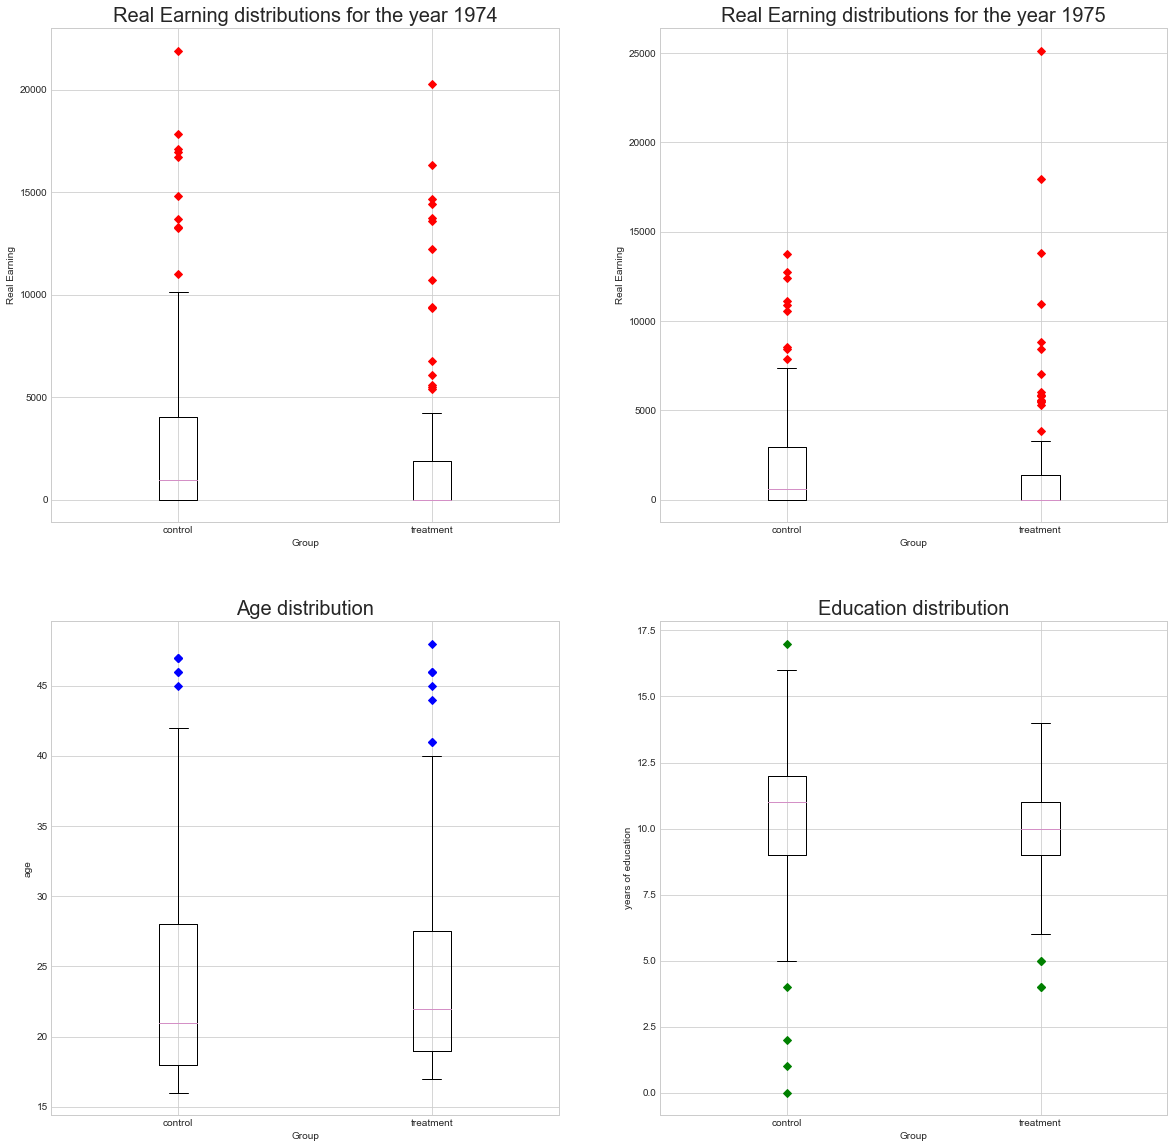

In [31]:
plt.figure(figsize=(20,20))

plt.subplot(221)
plt.boxplot([C2.re74,T2.re74],0, 'rD')
plt.ylabel('Real Earning')
plt.xlabel('Group')    
plt.title('Real Earning distributions for the year 1974',size=20)
plt.xticks([1,2],['control','treatment'])

plt.subplot(222)
plt.boxplot([C2.re75,T2.re75],0, 'rD')
plt.ylabel('Real Earning')
plt.xlabel('Group')    
plt.title('Real Earning distributions for the year 1975',size=20)
plt.xticks([1,2],['control','treatment'])

#boxplot for
plt.subplot(223)
plt.boxplot([C2.age,T2.age], 0, 'bD')    
plt.title('Age distribution',size=20)
plt.ylabel('age')
plt.xlabel('Group')    
plt.xticks([1,2],['control','treatment'])

plt.subplot(224)
plt.boxplot([C2.educ,T2.educ], 0, 'gD')    
plt.title('Education distribution',size=20)
plt.ylabel('years of education')
plt.xlabel('Group')    
plt.xticks([1,2],['control','treatment'])
plt.show()

We observe that the distributions for age and education is now similar (considering a one year difference not very important). The real earnings distribution however are now not as similar as in the previous matching.

In [32]:
#ratios 
#compute the number of black /hispanic/married/nodegree person in each group
C2_ratio=C2.iloc[:,4:8].sum()
T2_ratio=T2.iloc[:,4:8].sum()

#divide it by the total size of the group 
ratio=pd.DataFrame([100*C2_ratio/len(C2),100*T2_ratio/len(T2)])
ratio.index=['control','treatment']
np.round(ratio, decimals=2)

,black,hispan,married,nodegree
control,73.87,7.21,26.13,58.56
treatment,73.87,9.91,20.72,75.68


We see that our method succeeded in levelling the black ratios while keeping the rest of the ratios reasonably balanced.

**Conclusion:**
As the propensity scores are much better and the distribution of the problematic features are improved we decide to keep this matching.

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

#### Answer : 
We now ready to examine the distribution of the real earnings in 1978 for both groups created above.

([<matplotlib.axis.XTick at 0x2ee89382ac8>,
 <a list of 2 Text xticklabel objects>)

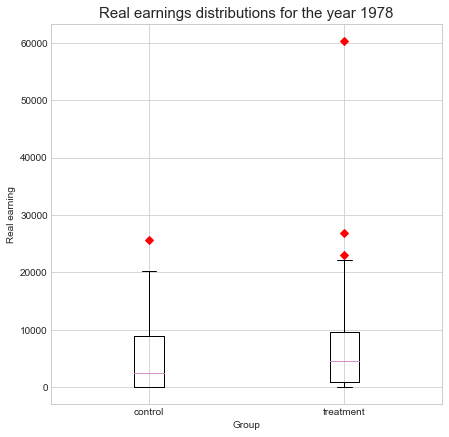

In [33]:
#create a figure
plt.figure(figsize=(7,7))
plt.boxplot([C2.re78,T2.re78],0, 'rD')
plt.ylabel('Real earning')
plt.xlabel('Group')    
plt.title('Real earnings distributions for the year 1978',size=15)
plt.xticks([1,2],['control','treatment'])

In [34]:
print('The real earning in 1978 were {}$ higher for the treatment group on average'.format(round(T2.re78.median() - C2.re78.median())))
print('The real ernings of the participants in the program improved by {}$ between 1975 and 1978 on average'.format(round(T2.re78.median() - T2.re75.median())))

The real earning in 1978 were 2079$ higher for the treatment group on average
The real ernings of the participants in the program improved by 4483$ between 1975 and 1978 on average


Unlike the naive analysis, the matched analysis allows us to conclude that the job trainning program actually had a positive effect on the participants real earnings.

# Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

## Part 1

- Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequencyâ€“inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

### Solution

Import libraries:

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

We retrieve the articles from the sklearn dataset. We can see the 20 categories that we are going to cluster the articles into. We decided to get the data in a random order so that we do not have to randomize the order later when splitting the data into training, testing and validation datasets.

In [3]:
#Fetch data. We download the data if it is not saved already.
newsgroups20 = fetch_20newsgroups(subset='all', shuffle=True, random_state=42, download_if_missing=True)

#20 news categories
categories = newsgroups20.target_names

#printing it!
print ("The 20 categories are:")
pprint(list(newsgroups20.target_names))


The 20 categories are:
['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [4]:
#Function to separate the documents into tokens by splitting on spaces and changing all characters to lowercase.
tokenize = lambda doc: doc.lower().split(" ")

# We create the sklearn TFIDF vectorizer, and compute the tfidf features of the data.
tfidf = TfidfVectorizer(tokenizer=tokenize)
tfidf_results = tfidf.fit_transform(newsgroups20.data)

print(tfidf_results)

  (0, 282387)	0.0140258057605
  (0, 365517)	0.113522139385
  (0, 237867)	0.11127683307
  (0, 450247)	0.110280777821
  (0, 123734)	0.117802347049
  (0, 423435)	0.430992321225
  (0, 268816)	0.147765943013
  (0, 451143)	0.121668965308
  (0, 434140)	0.0520731444266
  (0, 405733)	0.0896450297201
  (0, 197952)	0.0714324612804
  (0, 373078)	0.0757326847264
  (0, 428627)	0.0729556662549
  (0, 417615)	0.0744050019808
  (0, 77954)	0.083588891865
  (0, 431478)	0.136434968273
  (0, 150033)	0.108705621629
  (0, 506414)	0.0461762191086
  (0, 490927)	0.0306860931226
  (0, 173795)	0.13098527592
  (0, 402464)	0.0926395655756
  (0, 160883)	0.0460336953254
  (0, 437567)	0.0542189115102
  (0, 216675)	0.0854213348028
  (0, 137875)	0.0557677685832
  :	:
  (18845, 273981)	0.102179157679
  (18845, 104201)	0.102179157679
  (18845, 94404)	0.102179157679
  (18845, 225732)	0.102179157679
  (18845, 48685)	0.102179157679
  (18845, 31750)	0.102179157679
  (18845, 31749)	0.102179157679
  (18845, 153856)	0.10217915767

Next we separate the data into training, testing and validation data sets. We don't randomize it since we loaded the data in random order earlier.

In [5]:
data_len = len(newsgroups20.data)

data_80 = 8 * int(data_len / 10)
data_90 = 9 * int(data_len / 10)

#80% training data
train_tfidf = tfidf_results[:data_80]
train_data = newsgroups20['target'][:data_80]

#10% testing data
test_tfidf = tfidf_results[data_80:data_90]
test_data = newsgroups20['target'][data_80:data_90]

#10% validation data
val_tfidf = tfidf_results[data_90:]
val_data = newsgroups20['target'][data_90:]

print(train_tfidf.shape, test_tfidf.shape, val_tfidf.shape, train_data.shape, test_data.shape, val_data.shape)


(15072, 591946) (1884, 591946) (1890, 591946) (15072,) (1884,) (1890,)


## Part 2

- Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

Import libraries:

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV ,StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.externals import joblib

The first step for us is to create RandomForestClassifier object, and use the default parameters. After training the model, with the default parameters, we see that we have a prediction accuracy of `52.07%`

In [7]:
model = RandomForestClassifier()
model.fit(train_tfidf,train_data)
init_training_prediction = model.predict(test_tfidf)
init_training_score = accuracy_score(init_training_prediction,test_data)
init_training_score

0.52070063694267521

This function takes a value for the `max_depth` and for the `n_estimator`, trains a model with these values, and prints out the details of all the input and outputs of the function. We will use this when we run grid search.

In [8]:
def testRandomForest(depth, n_estimator):
        random_forest = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator, random_state=0)
        random_forest.fit(train_tfidf,train_data)
        prediction = random_forest.predict(val_tfidf)
        print("depth: "+str(depth)+"\t n_estimators: "+str(n_estimator)+"\t accuracy: "+str(accuracy_score(val_data, prediction)))
        return random_forest

Here we implemented grid search. We set a min and max for the `max_depth` and for the `n_estimator`, and we loop through all possible pairings of these values within these bounds. For each pairing we can see the accuracy. This computation was very time intensive, and so we ran it on a cluster. We have included some sample results below to illustrate how it works.

In [19]:
depth_init = 5
depth_max = 10
estim_init = 800
estim_max = 1000
        
for depth in range(depth_init, depth_max+1,5):
    for n_estimator in range(estim_init, estim_max+1,100):
        testRandomForest(depth, n_estimator)

depth: 5	 n_estimators: 800	 accuracy: 0.646560846561
depth: 5	 n_estimators: 900	 accuracy: 0.654497354497
depth: 5	 n_estimators: 1000	 accuracy: 0.657671957672
depth: 10	 n_estimators: 800	 accuracy: 0.703703703704
depth: 10	 n_estimators: 900	 accuracy: 0.706878306878
depth: 10	 n_estimators: 1000	 accuracy: 0.706349206349


After using grid search, we decided to use `max_depth = 50` and `n_estimator = 1800`. We could have further increase n_estimator, but doing so would have taken even more time, and the gain in accuracy would not be significant. Therefore we decided to train our model with these values.

As this is a time intensive computation, we saved our model to a pickle so that we can just load it up from next time.

In [11]:
trained_classifier = testRandomForest(50, 1800)

#dump to pickle
joblib.dump(trained_classifier, 'trained_classifier.pkl')

depth: 50	 n_estimators: 1800	 accuracy: 0.798412698413


['trained_classifier.pkl']

Here we are reading from the pickle

In [13]:
#load from pickle
trained_classifier = joblib.load('trained_classifier.pkl') 

In [14]:
test_prediction = trained_classifier.predict(test_tfidf)
test_score = accuracy_score(test_prediction,test_data)

We computed the new accuracy with our trained model after grid search, and we see the improved results.

In [15]:
test_score

0.77547770700636942

Below you can see our confusion matrix. 

In [38]:
cm = confusion_matrix(test_data , test_prediction)
print ("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[45  0  0  0  0  0  5  0  0  0  1  0  1  1  2 15  1  2  0  6]
 [ 0 54  9  3  0 11 16  0  0  0  0  0  1  0  0  0  1  0  1  0]
 [ 0  1 80  7  2  6  9  0  0  0  0  1  3  0  0  0  0  0  0  0]
 [ 1  2  6 58  3  4 19  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  1  2  5 70  2 13  1  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  2  4  0  0 87  3  0  0  0  1  0  0  1  0  0  0  0  0  0]
 [ 0  1  0  1  0  1 93  2  0  0  2  1  3  0  0  1  0  0  0  0]
 [ 0  2  1  1  0  0 12 95  4  2  0  0  2  1  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  8  2 81  0  0  1  0  0  1  0  0  0  0  0]
 [ 0  2  0  0  0  1  6  0  0 89  8  0  0  1  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  0  1 99  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  2  0  0  1  0 99  4  0  0  0  0  0  0  0]
 [ 0  3  2  2  1  1 10  1  0  0  1  1 54  0  3  1  1  0  0  0]
 [ 0  2  0  1  1  1 11  0  1  1  0  0  6 66  1  0  0  0  0  0]
 [ 0  4  0  0  0  1  8  0  0  0  0  0  1  1 73  0  2  0  0  0]
 [ 1  1  0  0  0  0  4  0  0  0  1  

Its a bit hard to get a good idea of the data in this format, so we also computed the normalized confusion matrix.

In [39]:
from numpy.linalg import norm
l1norm = norm(cm, axis=1, ord=1)
normalized_confustion_matrix = cm / l1norm.reshape(20,1)
print ("Normalized Confusion Matrix:\n", np.round(normalized_confustion_matrix, decimals=3))

Normalized Confusion Matrix:
 [[ 0.57  0.    0.    0.    0.    0.    0.06  0.    0.    0.    0.01  0.
   0.01  0.01  0.03  0.19  0.01  0.03  0.    0.08]
 [ 0.    0.56  0.09  0.03  0.    0.12  0.17  0.    0.    0.    0.    0.
   0.01  0.    0.    0.    0.01  0.    0.01  0.  ]
 [ 0.    0.01  0.73  0.06  0.02  0.06  0.08  0.    0.    0.    0.    0.01
   0.03  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.02  0.06  0.61  0.03  0.04  0.2   0.    0.    0.    0.    0.
   0.02  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.01  0.02  0.05  0.74  0.02  0.14  0.01  0.    0.    0.    0.
   0.01  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.02  0.04  0.    0.    0.89  0.03  0.    0.    0.    0.01  0.    0.
   0.01  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.01  0.    0.01  0.    0.01  0.89  0.02  0.    0.    0.02  0.01
   0.03  0.    0.    0.01  0.    0.    0.    0.  ]
 [ 0.    0.02  0.01  0.01  0.    0.    0.1   0.79  0.03  0.02  0.    0.
   0.02  0.01  0.01  0.    0.    

To get an even clearer idea of the data, we decided to plot this. In order to do so, we used sklearn's confusion matrix tutorial to get a nice plot of the confusion matrix.

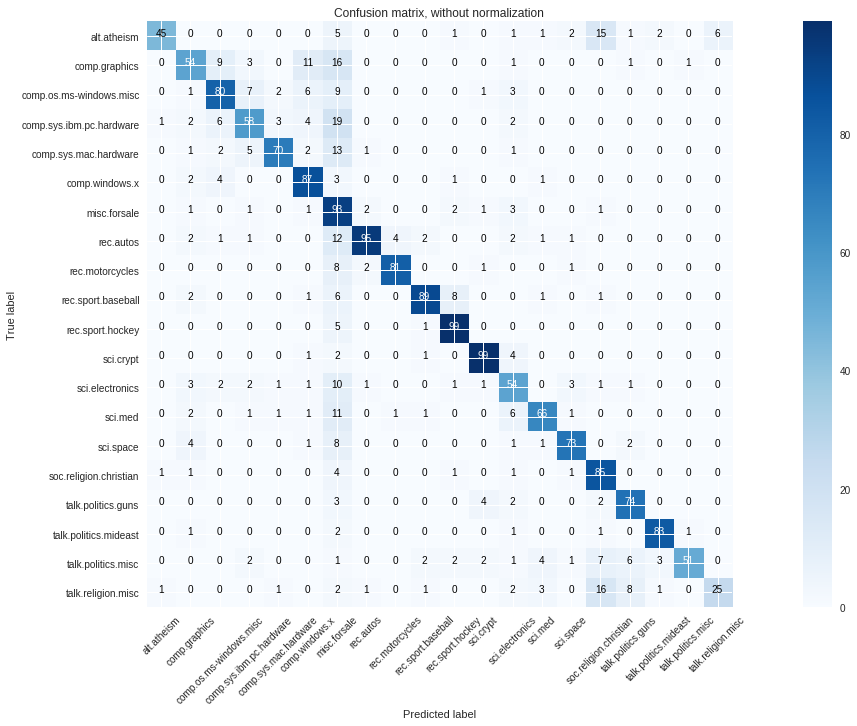

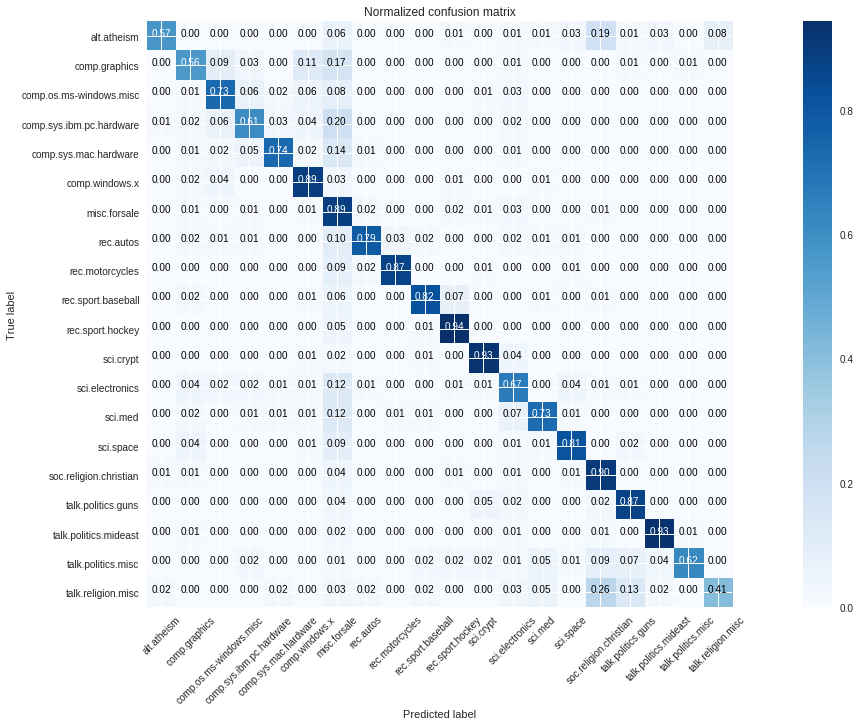

In [37]:
import itertools
def plot_confusion_matrix(cm, classes,title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

             
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(cm, classes=newsgroups20.target_names,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(normalized_confustion_matrix, classes=newsgroups20.target_names,title='Normalized confusion matrix')

plt.show()               
               


We notice some interesting things here. For example, 26% of items that should be classified as `talk.religion.misc` are instead classified as `soc.religion.christian`. Similarly 19% of items that should be classified as `alt.atheism` are also classified as `soc.religion.christian`. This suggests that while the classifier has predicted the wrong label, we can see that the missclassification is within topics related to religion, and not something completely random. Interestingly this did not occur in reverse (i.e. `soc.religion.christian` documents were not missclassifed in the above 2 categories).

Other observations we can make are that one of the most common missclassification is assigning the `misc.forsale` label, as well as a higher than average missclassification within the labels beginning with `comp`.


In [56]:
print(classification_report(test_data , test_prediction, target_names=newsgroups20.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.94      0.57      0.71        79
           comp.graphics       0.71      0.56      0.63        96
 comp.os.ms-windows.misc       0.77      0.73      0.75       109
comp.sys.ibm.pc.hardware       0.72      0.61      0.66        95
   comp.sys.mac.hardware       0.90      0.74      0.81        95
          comp.windows.x       0.75      0.89      0.81        98
            misc.forsale       0.40      0.89      0.55       105
               rec.autos       0.93      0.79      0.85       121
         rec.motorcycles       0.94      0.87      0.91        93
      rec.sport.baseball       0.92      0.82      0.87       108
        rec.sport.hockey       0.86      0.94      0.90       105
               sci.crypt       0.91      0.93      0.92       107
         sci.electronics       0.64      0.67      0.65        81
                 sci.med       0.85      0.73      0.78        91
         

We then examined the feature_importances to see how many words had an impact on our classification and which ones they were.

In [74]:
sortedFeatures = trained_classifier.feature_importances_

As extracting the feature importances takes time, we saved the results to a pickle

In [75]:
import pickle
pickle_out = open("sortedFeatures.pickle","wb")
pickle.dump(sortedFeatures, pickle_out)
pickle_out.close()

In [76]:
pickle_in = open("sortedFeatures.pickle","rb")
featureImp = pickle.load(pickle_in)
feature_names = tfidf.get_feature_names()

Now we can start the analysis:

In [77]:
feature_df = pd.DataFrame({'names':feature_names, 'featImp': featureImp})
print("Total number of features: ", len(feature_df))

Total number of features:  591946


Some of these features however may have no importance at all.

In [78]:
print("Features with 0 importance: ", len(feature_df[feature_df['featImp'] == 0]))

Features with 0 importance:  282099


In [80]:
percentage = round((len(feature_df[feature_df['featImp'] != 0]) / len(feature_df)),2)*100
print("This leaves us with ", percentage, " % features that have some degree of importance")

This leaves us with  52.0  % features that have some degree of importance


We decided to plot the distribution of the importance of these important features:

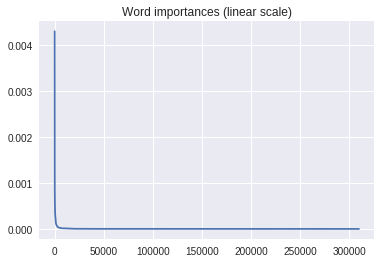

In [90]:
x = feature_df[feature_df['featImp'] != 0]

plt.plot(sorted(x["featImp"], reverse=True))
plt.title('Word importances (linear scale)')

Out of these, the 20 most important features are:

In [86]:
sorted_fdf = feature_df.sort_values(by=['featImp'], ascending=False)
sorted_fdf.head(20)

,featImp,names
571038,0.004309,windows
208577,0.003549,clipper
181350,0.003223,bike
256510,0.003116,encryption
196830,0.003027,car
493186,0.003015,space
309569,0.002769,hockey
451012,0.002752,re:
296447,0.002452,gun
581490,0.002410,x
